# Chat

Recall the overall workflow for retrieval augmented generation (RAG):

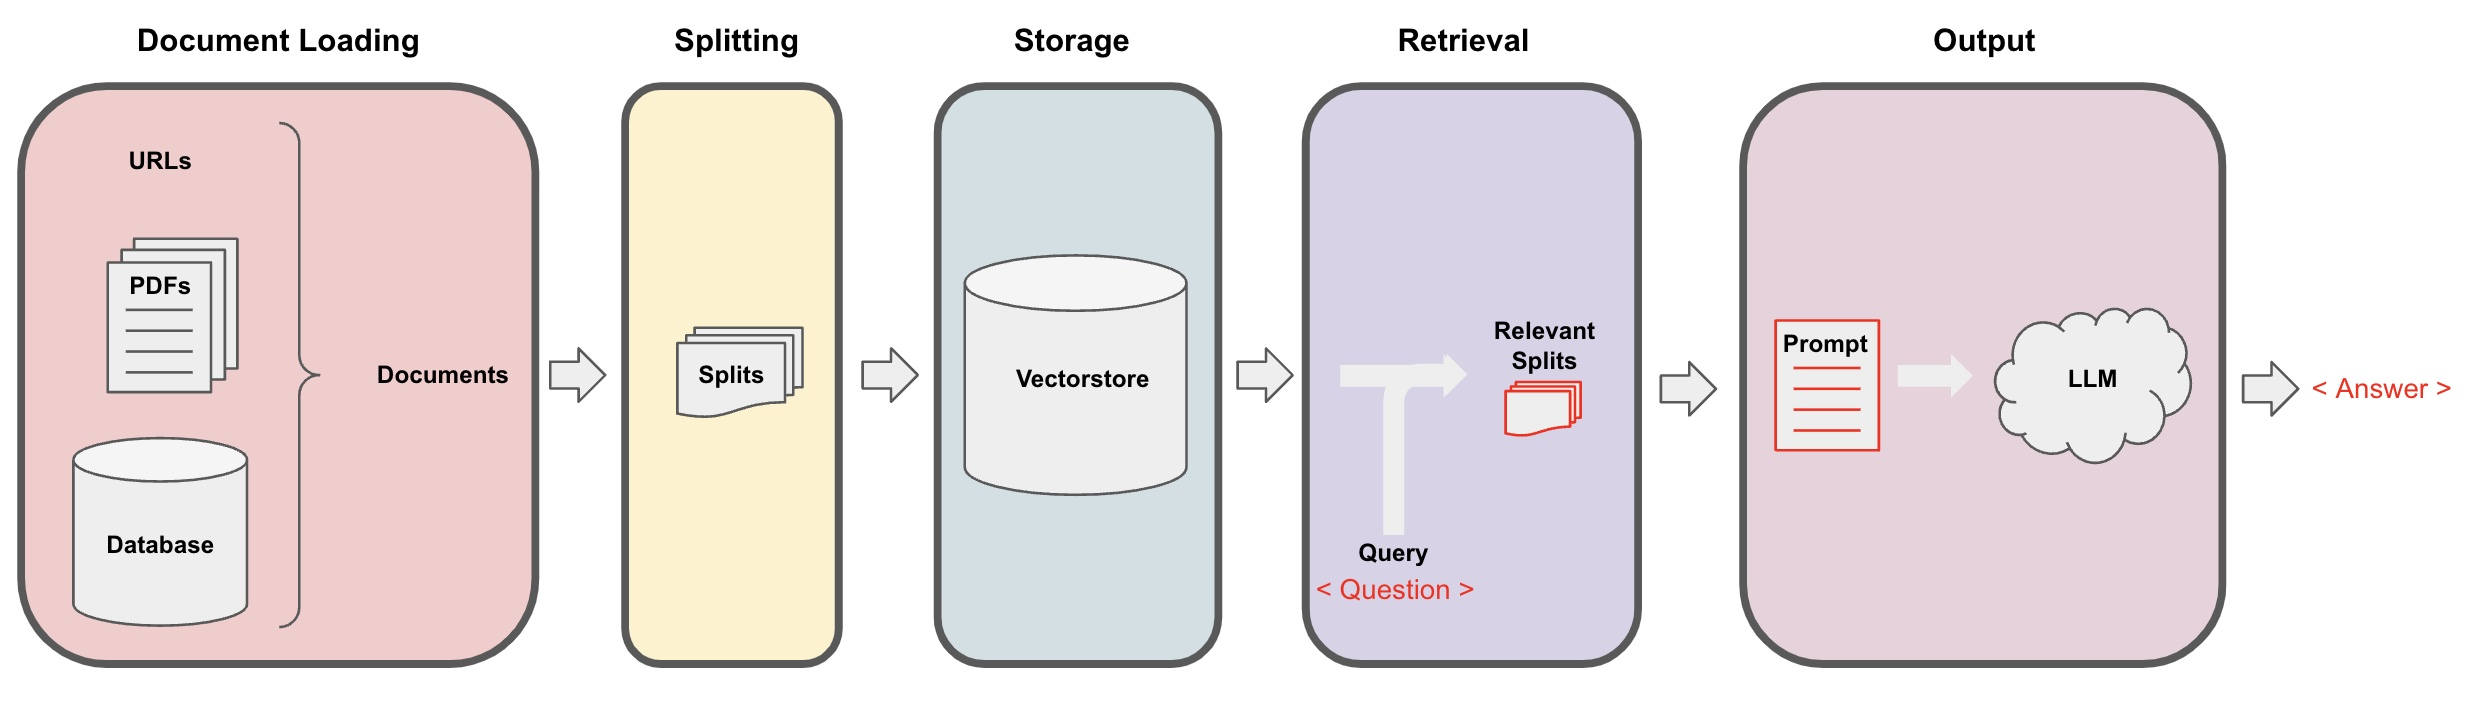

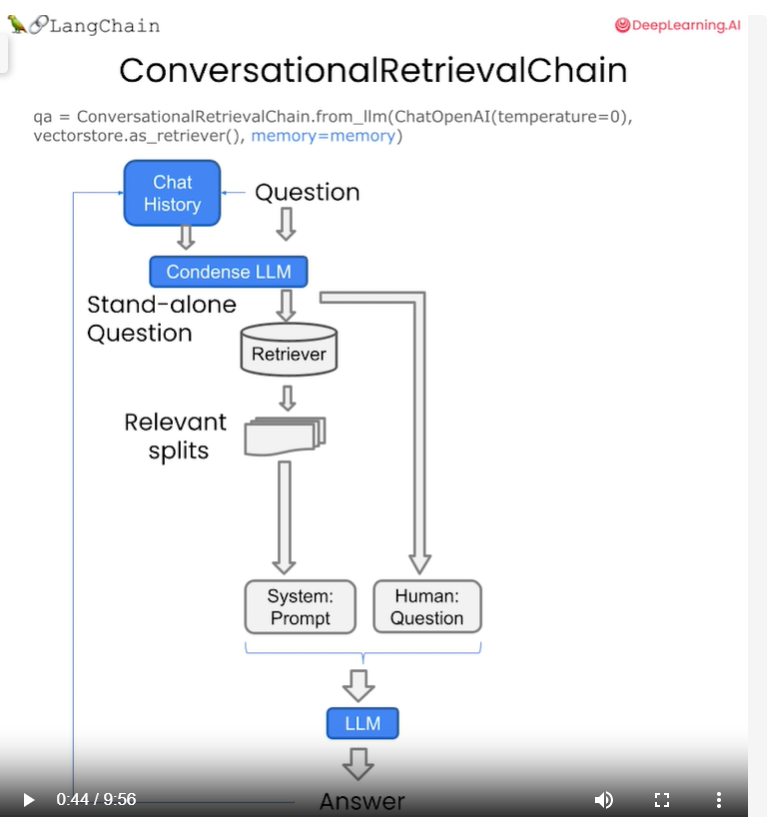

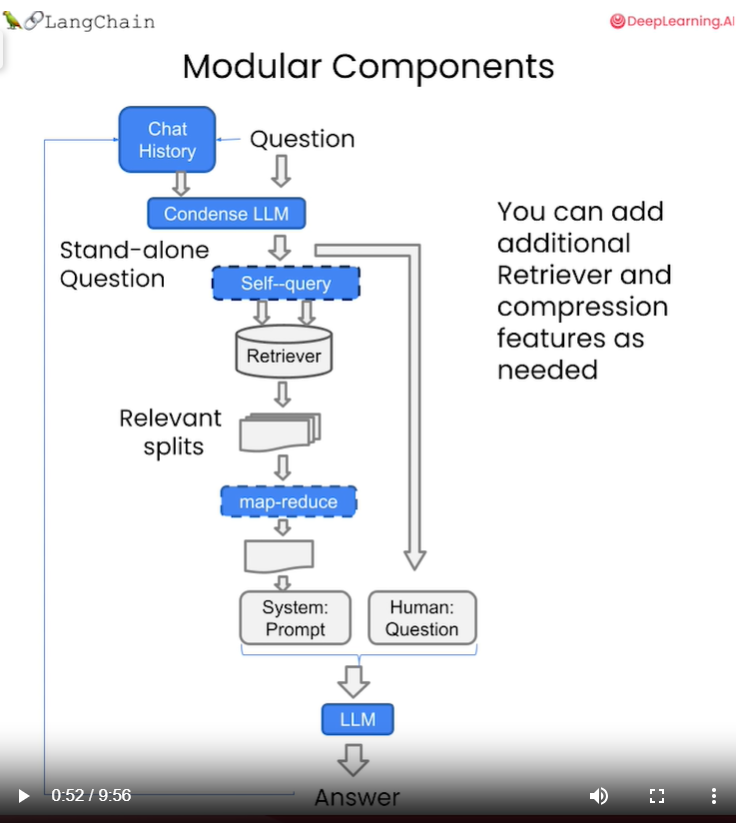



We discussed `Document Loading` and `Splitting` as well as `Storage` and `Retrieval`.

We then showed how `Retrieval` can be used for output generation in Q+A using `RetrievalQA` chain.

In [ ]:
import os
import openai
import sys
sys.path.append('../..')

import panel as pn  # GUI
pn.extension()

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

The code below was added to assign the openai LLM version filmed until it is deprecated, currently in Sept 2023. 
LLM responses can often vary, but the responses may be significantly different when using a different model version.

In [ ]:
import datetime
current_date = datetime.datetime.now().date()
if current_date < datetime.date(2023, 9, 2):
    llm_name = "gpt-3.5-turbo-0301"
else:
    llm_name = "gpt-3.5-turbo"
print(llm_name)

If you wish to experiment on `LangChain plus platform`:

 * Go to [langchain plus platform](https://www.langchain.plus/) and sign up
 * Create an api key from your account's settings
 * Use this api key in the code below 

In [ ]:
#import os
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_ENDPOINT"] = "https://api.langchain.plus"
#os.environ["LANGCHAIN_API_KEY"] = "..."

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
persist_directory = 'docs/chroma/'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

In [ ]:
question = "What are major topics for this class?"
docs = vectordb.similarity_search(question,k=3)
len(docs)

In [ ]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(model_name=llm_name, temperature=0)
llm.predict("Hello world!")

In [ ]:
# Build prompt
from langchain.prompts import PromptTemplate
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template,)

# Run chain
from langchain.chains import RetrievalQA
question = "Is probability a class topic?"
qa_chain = RetrievalQA.from_chain_type(llm,
                                       retriever=vectordb.as_retriever(),
                                       return_source_documents=True,
                                       chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})


result = qa_chain({"query": question})
result["result"]

### Memory

In [ ]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

### ConversationalRetrievalChain

In [ ]:
from langchain.chains import ConversationalRetrievalChain
retriever=vectordb.as_retriever()
qa = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=retriever,
    memory=memory
)

In [ ]:
question = "Is probability a class topic?"
result = qa({"question": question})

In [ ]:
result['answer']

In [ ]:
question = "why are those prerequesites needed?"
result = qa({"question": question})

In [ ]:
result['answer']

# Create a chatbot that works on your documents

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.document_loaders import TextLoader
from langchain.chains import RetrievalQA,  ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader

The chatbot code has been updated a bit since filming. The GUI appearance also varies depending on the platform it is running on.

In [ ]:
def load_db(file, chain_type, k):
    # load documents
    loader = PyPDFLoader(file)
    documents = loader.load()
    # split documents
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)
    docs = text_splitter.split_documents(documents)
    # define embedding
    embeddings = OpenAIEmbeddings()
    # create vector database from data
    db = DocArrayInMemorySearch.from_documents(docs, embeddings)
    # define retriever
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})
    # create a chatbot chain. Memory is managed externally.
    qa = ConversationalRetrievalChain.from_llm(
        llm=ChatOpenAI(model_name=llm_name, temperature=0), 
        chain_type=chain_type, 
        retriever=retriever, 
        return_source_documents=True,
        return_generated_question=True,
    )
    return qa 


In [ ]:
import panel as pn
import param

class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query  = param.String("")
    db_response = param.List([])
    
    def __init__(self,  **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        self.loaded_file = "docs/cs229_lectures/MachineLearning-Lecture01.pdf"
        self.qa = load_db(self.loaded_file,"stuff", 4)
    
    def call_load_db(self, count):
        if count == 0 or file_input.value is None:  # init or no file specified :
            return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")
        else:
            file_input.save("temp.pdf")  # local copy
            self.loaded_file = file_input.filename
            button_load.button_style="outline"
            self.qa = load_db("temp.pdf", "stuff", 4)
            button_load.button_style="solid"
        self.clr_history()
        return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")

    def convchain(self, query):
        if not query:
            return pn.WidgetBox(pn.Row('User:', pn.pane.Markdown("", width=600)), scroll=True)
        result = self.qa({"question": query, "chat_history": self.chat_history})
        self.chat_history.extend([(query, result["answer"])])
        self.db_query = result["generated_question"]
        self.db_response = result["source_documents"]
        self.answer = result['answer'] 
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=600)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#F6F6F6'}))
        ])
        inp.value = ''  #clears loading indicator when cleared
        return pn.WidgetBox(*self.panels,scroll=True)

    @param.depends('db_query ', )
    def get_lquest(self):
        if not self.db_query :
            return pn.Column(
                pn.Row(pn.pane.Markdown(f"Last question to DB:", styles={'background-color': '#F6F6F6'})),
                pn.Row(pn.pane.Str("no DB accesses so far"))
            )
        return pn.Column(
            pn.Row(pn.pane.Markdown(f"DB query:", styles={'background-color': '#F6F6F6'})),
            pn.pane.Str(self.db_query )
        )

    @param.depends('db_response', )
    def get_sources(self):
        if not self.db_response:
            return 
        rlist=[pn.Row(pn.pane.Markdown(f"Result of DB lookup:", styles={'background-color': '#F6F6F6'}))]
        for doc in self.db_response:
            rlist.append(pn.Row(pn.pane.Str(doc)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    @param.depends('convchain', 'clr_history') 
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(pn.Row(pn.pane.Str("No History Yet")), width=600, scroll=True)
        rlist=[pn.Row(pn.pane.Markdown(f"Current Chat History variable", styles={'background-color': '#F6F6F6'}))]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    def clr_history(self,count=0):
        self.chat_history = []
        return 


### Create a chatbot

In [ ]:
cb = cbfs()

file_input = pn.widgets.FileInput(accept='.pdf')
button_load = pn.widgets.Button(name="Load DB", button_type='primary')
button_clearhistory = pn.widgets.Button(name="Clear History", button_type='warning')
button_clearhistory.on_click(cb.clr_history)
inp = pn.widgets.TextInput( placeholder='Enter text here…')

bound_button_load = pn.bind(cb.call_load_db, button_load.param.clicks)
conversation = pn.bind(cb.convchain, inp) 

jpg_pane = pn.pane.Image( './img/convchain.jpg')

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=300),
    pn.layout.Divider(),
)
tab2= pn.Column(
    pn.panel(cb.get_lquest),
    pn.layout.Divider(),
    pn.panel(cb.get_sources ),
)
tab3= pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)
tab4=pn.Column(
    pn.Row( file_input, button_load, bound_button_load),
    pn.Row( button_clearhistory, pn.pane.Markdown("Clears chat history. Can use to start a new topic" )),
    pn.layout.Divider(),
    pn.Row(jpg_pane.clone(width=400))
)
dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# ChatWithYourData_Bot')),
    pn.Tabs(('Conversation', tab1), ('Database', tab2), ('Chat History', tab3),('Configure', tab4))
)
dashboard

Feel free to copy this code and modify it to add your own features. You can try alternate memory and retriever models by changing the configuration in `load_db` function and the `convchain` method. [Panel](https://panel.holoviz.org/) and [Param](https://param.holoviz.org/) have many useful features and widgets you can use to extend the GUI.


## Acknowledgments

Panel based chatbot inspired by Sophia Yang, [github](https://github.com/sophiamyang/tutorials-LangChain)